# The Python Almanac

The world of Python packages is adventurous and can be confusing at times.
Here, I try to aggregate and showcase a diverse set of Python packages which have become useful at some point.

## Introduction

### Installing Python

Normally you should use your system's package manager.
In case of problems, try [pyenv](https://github.com/pyenv/pyenv):

```bash
$ pyenv versions
$ pyenv install <foo>
$ pyenv global <foo>
```

This will install the specified Python version to `$(pyenv root)/versions`.

### Installing packages

Python packages can be easily installed from [PyPI (Python Package Index)](https://pypi.org/):

```bash
$ pip install --user <package> (local install does not clash with system packages)
```

Using `--user` will install the package only for the current user. This is good if multiple users need different package versions, but can lead to redundant installations.

To install from a git repository, use the following command:

```bash
$ pip install --user -U git+https://github.com/<user>/<repository>@<branch>
```

### Package management

While packages can be installed globally or user-specific, it often makes sense to create project-specific virtual environments.

This can be easily accomplished using [venv](https://docs.python.org/3/library/venv.html):

```bash
$ python -m venv my_venv
$ . venv/bin/activate
$ pip install <package>
```

## Software development

### Package Distribution

Use `setuptools`.
[poetry](https://github.com/sdispater/poetry) handles many otherwise slightly annoying things:
```
$ poetry init/add/install/run/publish
```

CI encapsulation: [tox](https://github.com/tox-dev/tox).

Keeping track of version numbers can be achieved using [bump2version](https://github.com/c4urself/bump2version).

Transform between various project file formats using [dephell](https://github.com/dephell/dephell).

### Testing

Setup testing using [pytest](https://github.com/pytest-dev/pytest). It has a wide range of useful features, such as fixtures (modularized per-test setup code) and test parametrization (quickly execute the same test for multiple inputs).

In [1]:
%%writefile /tmp/tests.py

import os
import pytest


@pytest.fixture(scope='session')
def custom_directory(tmp_path_factory):
    return tmp_path_factory.mktemp('workflow_test')


def test_fixture_execution(custom_directory):
    assert os.path.isdir(custom_directory)


@pytest.mark.parametrize('expression_str,result', [
    ('2+2', 4), ('2*2', 4), ('2**2', 4)
])
def test_expression_evaluation(expression_str, result):
    assert eval(expression_str) == result

Overwriting /tmp/tests.py


In [2]:
!pytest -v /tmp/tests.py

============================= test session starts ==============================
platform darwin -- Python 3.8.6, pytest-6.2.2, py-1.10.0, pluggy-0.13.1 -- /Users/kimja/.pyenv/versions/3.8.6/bin/python3.8
cachedir: .pytest_cache
rootdir: /tmp
plugins: anyio-2.0.2
collected 4 items                                                              

../../../../../../../../tmp/tests.py::test_fixture_execution PASSED      [ 25%]
../../../../../../../../tmp/tests.py::test_expression_evaluation[2+2-4] PASSED [ 50%]
../../../../../../../../tmp/tests.py::test_expression_evaluation[2*2-4] PASSED [ 75%]
../../../../../../../../tmp/tests.py::test_expression_evaluation[2**2-4] PASSED [100%]

============================== 4 passed in 0.04s ===============================


### Linting/Formatting

Linters and code formatters improve the quality of your Python code by conducting a static analysis and flagging issues.

* [flake8](https://github.com/PyCQA/flake8): Catch various common errors and adhere to PEP8. Supports many [plugins](https://github.com/DmytroLitvinov/awesome-flake8-extensions).
* [pylint](https://github.com/PyCQA/pylint): Looks for even more sources of code smell.
* [black](https://github.com/psf/black): "*the* uncompromising Python code formatter".

While there can be a considerable overlap between the tools' outputs, each offers its own advantages and they can typically be used together.

### Profiling

Code profiling tools are a great way of finding parts of your code which can be optimized.
They come in various flavors:

* [line_profiler](https://github.com/pyutils/line_profiler): which parts of the code require most execution time
* [memory_profiler](https://github.com/pythonprofilers/memory_profiler): which parts of the code consume the most memory

Consider the following script (note the `@profile` decorator):

In [3]:
%%writefile /tmp/script.py

@profile
def main():
    # takes a long time
    for _ in range(100_000):
        1337**42

    # requires a lot of memory
    arr = [1] * 1_000_000
    
main()

Overwriting /tmp/script.py


#### line_profiler

In [4]:
!kernprof -l -v -o /tmp/script.py.lprof /tmp/script.py

Wrote profile results to /tmp/script.py.lprof
Timer unit: 1e-06 s

Total time: 0.148111 s
File: /tmp/script.py
Function: main at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profile
     3                                           def main():
     4                                               # takes a long time
     5    100001      37580.0      0.4     25.4      for _ in range(100_000):
     6    100000     106182.0      1.1     71.7          1337**42
     7                                           
     8                                               # requires a lot of memory
     9         1       4349.0   4349.0      2.9      arr = [1] * 1_000_000



#### memory_profiler

In [5]:
!python3 -m memory_profiler /tmp/script.py

Filename: /tmp/script.py

Line #    Mem usage    Increment  Occurences   Line Contents
     2   37.684 MiB   37.684 MiB           1   @profile
     3                                         def main():
     4                                             # takes a long time
     5   37.684 MiB -222259.711 MiB      100001       for _ in range(100_000):
     6   37.684 MiB -222254.953 MiB      100000           1337**42
     7                                         
     8                                             # requires a lot of memory
     9   37.438 MiB   -0.246 MiB           1       arr = [1] * 1_000_000




### Debugging

#### Raw python

[ipdb](https://github.com/gotcha/ipdb) is useful Python commandline debugger.
To invoke it, simply put `import ipdb; ipdb.set_trace()` in your code.
Starting with Python 3.7, you can also write `breakpoint()`. This honors the `PYTHONBREAKPOINT` environment variable.
To automatically start the debugger when an error occurs, run your script with `python -m ipdb -c continue <script>`.

The debugger supports various commands:
* p: print expression
* pp: pretty print
* n: next line in current function
* s: execute current line and stop at next possible location (e.g. in function call)
* c: continue execution
* unt: execute until we reach greater line
* l: list source (`l .`)
* ll: whole source code of current function
* b: breakpoint (`[ ([filename:]lineno | function) [, condition] ]`)
* w/bt: print stack trace
* u: move up the stack trace
* d: move down the stack trace
* h: help
* q: quit

#### C++ extension:
Open two windows: ipython, ldb (gdb)

In [1]: !ps aux | grep -i ipython
(lldb) attach --pid 1234
(lldb) continue

(lldb) breakpoint set -f myfile.cpp -l 400

In [2]: run myscript.py

### Documentation

sphinx, nbsphinx

### Logging

There are various built-in and third-party logging modules available.

In [6]:
from loguru import logger

In [7]:
logger.debug('Helpful debug message')
logger.error('oh no')

2021-01-28 23:17:11.204 | DEBUG    | __main__:<module>:1 - Helpful debug message


2021-01-28 23:17:11.205 | ERROR    | __main__:<module>:2 - oh no


## Data Science

### SciPy

[SciPy](https://www.scipy.org/) is comprised of various popular Python modules which are for scientific computations.

[Numpy](https://numpy.org/) can be used for a multitude of things.

In [8]:
import numpy as np

In [9]:
data = np.random.normal(size=(100, 3))

In [10]:
data[:10, :]

array([[ 0.73627467,  2.07304791,  1.60425106],
       [-0.18979345,  1.6737833 ,  0.10110279],
       [ 1.26125065,  0.05310833,  0.66193115],
       [-1.98143753,  0.55989844,  0.37752932],
       [ 0.79409975,  0.47152455, -0.1455592 ],
       [ 0.76550564,  0.38608807,  0.67553302],
       [-0.04006774,  0.86416024, -1.07370177],
       [ 0.41378545, -2.0640186 ,  0.96974267],
       [-0.70525183,  0.23132466, -1.41343703],
       [-0.07360206,  0.53807524,  0.12715455]])

### Dataframes

Organizing your data in dataframes using [pandas](https://pandas.pydata.org/) makes nearly everything easier.

In [11]:
import pandas as pd

In [12]:
df = pd.DataFrame(data, columns=['A', 'B', 'C'])
df['group'] = np.random.choice(['G1', 'G2'], size=df.shape[0])

In [13]:
df.head()

,A,B,C,group
0,0.736275,2.073048,1.604251,G2
1,-0.189793,1.673783,0.101103,G2
2,1.261251,0.053108,0.661931,G2
3,-1.981438,0.559898,0.377529,G1
4,0.794100,0.471525,-0.145559,G1


### Networkx

[Networkx](https://github.com/networkx/networkx) is a wonderful library for conducting network analysis.

In [14]:
import networkx as nx

In [15]:
graph = nx.watts_strogatz_graph(100, 4, 0.1)
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 200
Average degree:   4.0000


In [16]:
pos = nx.drawing.nx_agraph.graphviz_layout(graph, prog='neato', args='-Goverlap=scale')
list(pos.items())[:3]

[(0, (1881.9, 1151.2)), (1, (2253.3, 885.14)), (2, (2127.7, 798.25))]

In [17]:
node_clustering = nx.clustering(graph)
list(node_clustering.items())[:3]

[(0, 0.1), (1, 0.5), (2, 0.4)]

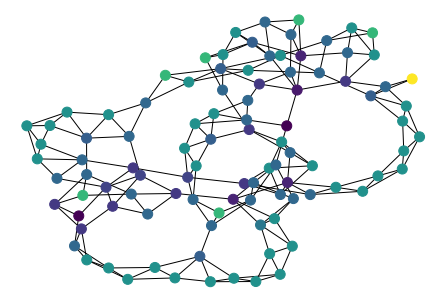

In [18]:
nx.draw(
    graph,
    pos,
    node_size=100,
    nodelist=list(node_clustering.keys()),
    node_color=list(node_clustering.values()),
)

### Plotting

#### Matplotlib

[Matplotlib](https://matplotlib.org/) is the de facto standard plotting library for Python.

In [19]:
import matplotlib.pyplot as plt

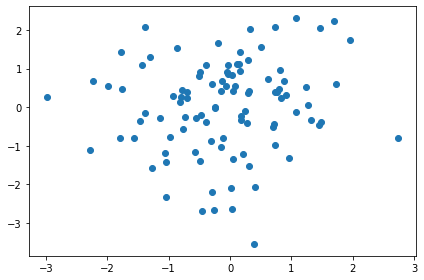

In [20]:
fig, ax = plt.subplots()

ax.scatter(data[:, 0], data[:, 1])

fig.tight_layout()

Axis ticks can be formatted in a multitude of different [ways](https://matplotlib.org/api/ticker_api.html#tick-formatting).
The most versatile way is probably `FuncFormatter`.

In [21]:
from matplotlib.ticker import FuncFormatter

In [22]:
@FuncFormatter
def my_formatter(x, pos):
    return f'{x=}, {pos=}'

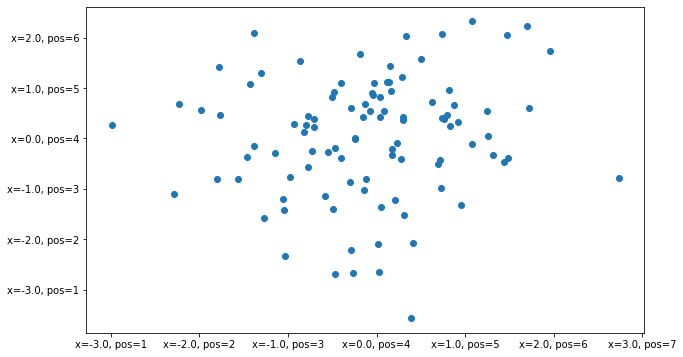

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(data[:, 0], data[:, 1])

ax.xaxis.set_major_formatter(my_formatter)
ax.yaxis.set_major_formatter(my_formatter)

#### Seaborn

[Seaborn](https://seaborn.pydata.org/) makes working with dataframes and creating commonly used plots accessible and comfortable.

In [24]:
import seaborn as sns

In [25]:
# first convert dataframe from wide to long format
df_long = pd.melt(df, id_vars=['group'])
df_long.head()

,group,variable,value
0,G2,A,0.736275
1,G2,A,-0.189793
2,G2,A,1.261251
3,G1,A,-1.981438
4,G1,A,0.794100


<AxesSubplot:xlabel='variable', ylabel='value'>

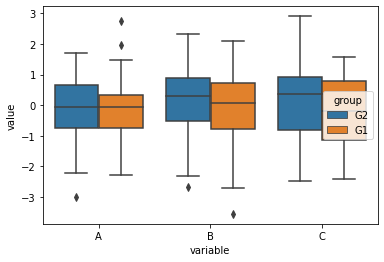

In [26]:
sns.boxplot(data=df_long, x='variable', y='value', hue='group')

#### Statannot

[Statannot](https://github.com/webermarcolivier/statannot) can be used to quickly add markers of significance to comparison plots.

In [27]:
import statannot

B_G1 v.s. B_G2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.916e-01 U_stat=1.190e+03


(<AxesSubplot:xlabel='variable', ylabel='value'>,
 [<statannot.StatResult.StatResult at 0x13c800640>])

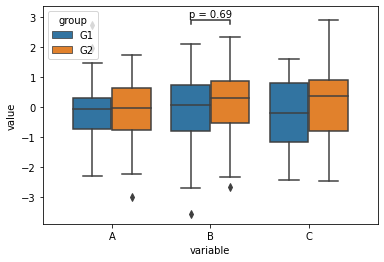

In [28]:
ax = sns.boxplot(
    data=df_long,
    x='variable',
    y='value',
    hue='group',
    order=['A', 'B', 'C'],
    hue_order=['G1', 'G2'],
)

statannot.add_stat_annotation(
    ax,
    plot='barplot',
    data=df_long,
    x='variable',
    y='value',
    hue='group',
    order=['A', 'B', 'C'],
    hue_order=['G1', 'G2'],
    box_pairs=[(('B', 'G1'), ('B', 'G2'))],
    text_format='simple',
    test='Mann-Whitney',
)

#### Brokenaxes

[Brokenaxes](https://github.com/bendichter/brokenaxes) can be used to include outliers in a plot without messing up the axis range. Note that this can be quite misleading.

In [29]:
import brokenaxes

[{'whiskers': [<matplotlib.lines.Line2D at 0x13c972ee0>,
  'caps': [<matplotlib.lines.Line2D at 0x13c983760>,
  'boxes': [<matplotlib.lines.Line2D at 0x13c97c5b0>,
  'medians': [<matplotlib.lines.Line2D at 0x13c983e20>,
  'fliers': [<matplotlib.lines.Line2D at 0x13c9911c0>,
  'means': []},
 {'whiskers': [<matplotlib.lines.Line2D at 0x13c99df70>,
  'caps': [<matplotlib.lines.Line2D at 0x13c9a8670>,
  'boxes': [<matplotlib.lines.Line2D at 0x13c99dc10>,
  'medians': [<matplotlib.lines.Line2D at 0x13c9a8d30>,
  'fliers': [<matplotlib.lines.Line2D at 0x13c9b40d0>,
  'means': []}]

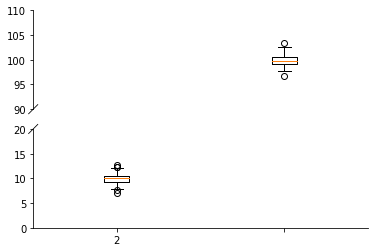

In [30]:
bax = brokenaxes.brokenaxes(ylims=((0, 20), (90, 110)))
bax.boxplot([np.random.normal(10, size=100), np.random.normal(100, size=100)])

#### Adjusttext

[Adjusttext](https://github.com/Phlya/adjustText) can help for plots with many labels which potentially overlap.

In [31]:
from adjustText import adjust_text

106

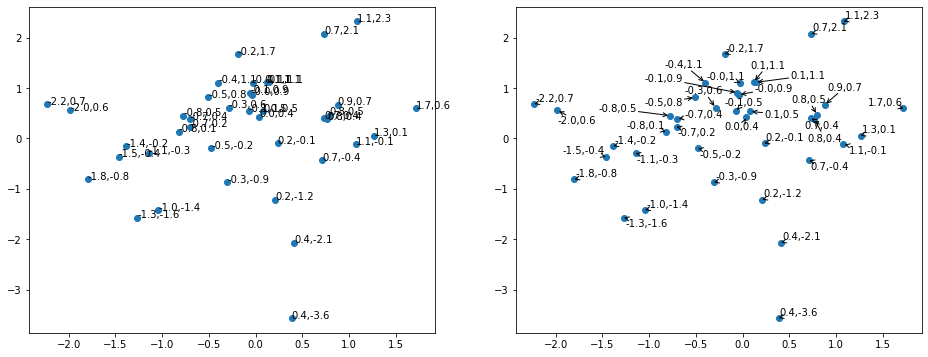

In [32]:
data_sub = data[:40, :]
fig, (ax_raw, ax_adj) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax_raw.scatter(data_sub[:, 0], data_sub[:, 1])
[
    ax_raw.annotate(f'{round(x, 1)},{round(y, 1)}', xy=(x, y))
    for x, y in data_sub[:, [0, 1]]
]

ax_adj.scatter(data_sub[:, 0], data_sub[:, 1])
adjust_text(
    [
        ax_adj.annotate(f'{round(x, 1)},{round(y, 1)}', xy=(x, y))
        for x, y in data_sub[:, [0, 1]]
    ],
    arrowprops=dict(arrowstyle='->'),
)

#### Plotnine

While matplotlib's pyplot provides a similar plotting interface as MATLAB, [plotnine](https://github.com/has2k1/plotnine) implements a grammar of graphics and is (in ideology) based on R's [ggplot2](https://github.com/tidyverse/ggplot2).

In [33]:
import plotnine

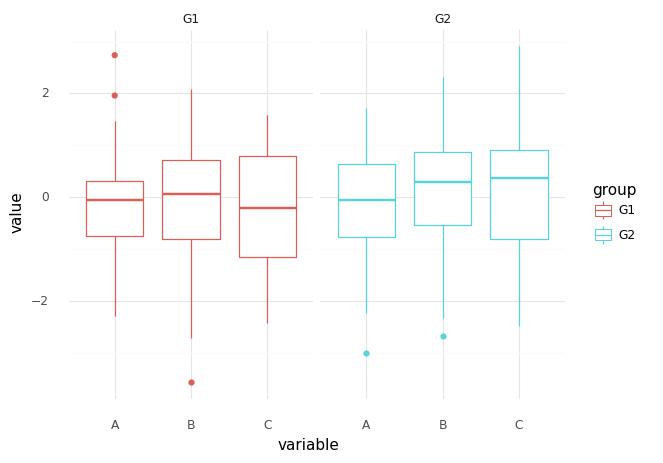

<ggplot: (337384867)>

In [34]:
(
    plotnine.ggplot(df_long, plotnine.aes(x='variable', y='value', color='group'))
    + plotnine.geom_boxplot()
    + plotnine.facet_wrap('~group')
    + plotnine.theme_minimal()
)

#### Folium

[Folium](https://github.com/python-visualization/folium) is a Python wrapper of the [Leaflet.js](https://leafletjs.com/) library to visualize dynamic maps.

In [35]:
import folium

In [36]:
folium.Map(
    location=[np.random.uniform(40, 70), np.random.uniform(10, 30)],
    zoom_start=7,
    width=500,
    height=500,
)

### High performance

When dealing with large amounts of data or many computations, it can make sense to optimize hotspots in C++ or use specialized libraries.

#### Dask

[Dask](https://github.com/dask/dask) provides a Panda's like interface to high-performance dataframes which support out-of-memory processing, cluster distribution, and more.
It is particularly useful when the dataframe does not fit in RAM anymore. Common operations operate on chunks of the dataframe and are only executed when explicitly requested.

In [37]:
import dask.dataframe as dd

In [38]:
df = pd.DataFrame(np.random.normal(size=(1_000_000, 2)), columns=['A', 'B'])

In [39]:
ddf = dd.from_pandas(df, npartitions=4)
ddf.head()

,A,B
0,0.285151,0.245593
1,-1.902585,1.831842
2,-0.582446,-0.037622
3,-2.069846,0.358500
4,-1.424906,-0.320222


In [40]:
ddf['A'] + ddf['B']

Dask Series Structure:
npartitions=4
0         float64
250000        ...
500000        ...
750000        ...
999999        ...
dtype: float64
Dask Name: add, 16 tasks

In [41]:
(ddf['A'] + ddf['B']).compute()

0         0.530745
1        -0.070743
2        -0.620069
3        -1.711347
4        -1.745128
            ...   
999995    0.399192
999996   -0.783770
999997    1.407576
999998    1.048654
999999    0.476440
Length: 1000000, dtype: float64

#### Vaex

[Vaex](https://github.com/vaexio/vaex) fills a similar niche as dask and makes working with out-of-core dataframe easy.
It has a slightly more intuitive interface and offers many cool visualizations right out of the box.

In [42]:
import vaex as vx

In [43]:
vdf = vx.from_pandas(df)
vdf.head()

#,A,B
0,0.285151,0.245593
1,-1.90258,1.83184
2,-0.582446,-0.0376225
3,-2.06985,0.3585
4,-1.42491,-0.320222
5,-1.94587,-0.396723
6,-2.09466,1.19457
7,-0.0123898,0.856249
8,-0.126541,0.617549
9,1.09255,-0.68878


In [44]:
vdf['A'] + vdf['B']

Expression = (A + B)
Length: 1,000,000 dtype: float64 (expression)
---------------------------------------------
     0   0.530745
     1  -0.070743
     2  -0.620069
     3   -1.71135
     4   -1.74513
       ...       
999995   0.399192
999996   -0.78377
999997    1.40758
999998    1.04865
999999    0.47644

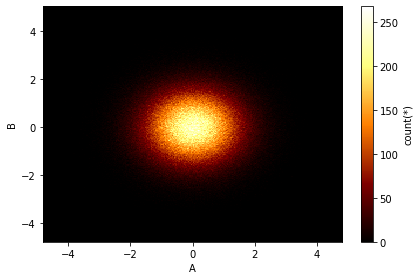

In [45]:
vdf.plot(vdf['A'], vdf['B'])

#### Joblib

[Joblib](https://github.com/joblib/joblib) makes executing functions in parallel very easy and removes boilerplate code.

In [46]:
import time
import random

import joblib

In [47]:
def heavy_function(i):
    print(f'{i=}')
    time.sleep(random.random())
    return i ** i

In [48]:
joblib.Parallel(n_jobs=2)([joblib.delayed(heavy_function)(i) for i in range(10)])

[1, 1, 4, 27, 256, 3125, 46656, 823543, 16777216, 387420489]

#### Swifter

Choosing the correct way of parallelizing your computations can be non-trivial. [Swifter](https://github.com/jmcarpenter2/swifter) tries to automatically select the most suitable one.

In [49]:
import swifter

In [50]:
df_big = pd.DataFrame({'A': np.random.randint(0, 100, size=1_000_000)})
df_big.head()

,A
0,24
1,8
2,13
3,7
4,99


In [51]:
%%timeit
df_big['A'].apply(lambda x: x ** 2)

539 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%%timeit
df_big['A'].swifter.apply(lambda x: x ** 2)

3.01 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Bioinformatics

#### PyRanges

[PyRanges](https://github.com/biocore-ntnu/pyranges) makes working with genomic ranges easy as pie.

In [53]:
import pyranges as pr

In [54]:
df_exons = pr.data.exons()
df_exons

+--------------+-----------+-----------+-------+
| Chromosome   | Start     | End       | +3    |
| (category)   | (int32)   | (int32)   | ...   |
|--------------+-----------+-----------+-------|
| chrX         | 135721701 | 135721963 | ...   |
| chrX         | 135574120 | 135574598 | ...   |
| chrX         | 47868945  | 47869126  | ...   |
| chrX         | 77294333  | 77294480  | ...   |
| ...          | ...       | ...       | ...   |
| chrY         | 15409586  | 15409728  | ...   |
| chrY         | 15478146  | 15478273  | ...   |
| chrY         | 15360258  | 15361762  | ...   |
| chrY         | 15467254  | 15467278  | ...   |
+--------------+-----------+-----------+-------+
Stranded PyRanges object has 1,000 rows and 6 columns from 2 chromosomes.
For printing, the PyRanges was sorted on Chromosome and Strand.
3 hidden columns: Name, Score, Strand

In [55]:
df_locus = pr.PyRanges(
    pd.DataFrame({'Chromosome': ['chrX'], 'Start': [1_400_000], 'End': [1_500_000]})
)
df_locus

+--------------+-----------+-----------+
| Chromosome   |     Start |       End |
| (category)   |   (int32) |   (int32) |
|--------------+-----------+-----------|
| chrX         |   1400000 |   1500000 |
+--------------+-----------+-----------+
Unstranded PyRanges object has 1 rows and 3 columns from 1 chromosomes.
For printing, the PyRanges was sorted on Chromosome.

In [56]:
df_exons.overlap(df_locus).df

,Chromosome,Start,End,Name,Score,Strand
0,chrX,1475113,1475229,NM_001267713_exon_4_0_chrX_1475114_f,0,+
1,chrX,1419383,1419519,NM_001161531_exon_9_0_chrX_1419384_f,0,+
2,chrX,1424338,1424420,NM_006140_exon_11_0_chrX_1424339_f,0,+
3,chrX,1407651,1407781,NM_001161532_exon_3_0_chrX_1407652_f,0,+
4,chrX,1404670,1404813,NM_172245_exon_3_0_chrX_1404671_f,0,+
5,chrX,1424338,1424420,NM_001161530_exon_10_0_chrX_1424339_f,0,+
6,chrX,1414319,1414349,NM_172245_exon_8_0_chrX_1414320_f,0,+
7,chrX,1407411,1407535,NM_172249_exon_4_0_chrX_1407412_f,0,+


#### Obonet

[Obonet](https://github.com/dhimmel/obonet) is a library for working with (OBO-formatted) ontologies.

In [57]:
import obonet

In [58]:
url = 'https://github.com/DiseaseOntology/HumanDiseaseOntology/raw/main/src/ontology/HumanDO.obo'
graph = obonet.read_obo(url)

In [59]:
list(graph.nodes(data=True))[0]

('DOID:0001816',
 {'name': 'angiosarcoma',
  'alt_id': ['DOID:267', 'DOID:4508'],
  'def': '"A vascular cancer that derives_from the cells that line the walls of blood vessels or lymphatic vessels." [url:http\\://en.wikipedia.org/wiki/Hemangiosarcoma, url:https\\://en.wikipedia.org/wiki/Angiosarcoma, url:https\\://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI_Thesaurus&ns=ncit&code=C3088, url:https\\://www.ncbi.nlm.nih.gov/pubmed/23327728]',
  'subset': ['DO_cancer_slim', 'NCIthesaurus'],
  'synonym': ['"hemangiosarcoma" EXACT []'],
  'xref': ['MESH:D006394',
   'NCI:C3088',
   'NCI:C9275',
   'SNOMEDCT_US_2020_03_01:39000009',
   'UMLS_CUI:C0018923',
   'UMLS_CUI:C0854893'],
  'is_a': ['DOID:175']})

### Statistics/Machine Learning

#### Statsmodels

[Statsmodels](https://github.com/statsmodels/statsmodels) helps with statistical modelling.

In [60]:
import statsmodels.formula.api as smf

In [61]:
df_data = pd.DataFrame({'X': np.random.normal(size=100)})

df_data['Y'] = 1.3 * df_data['X'] + 4.2

df_data.head()

,X,Y
0,1.541800,6.204340
1,0.562578,4.931351
2,0.635968,5.026759
3,-1.491444,2.261123
4,1.188706,5.745317


In [62]:
mod = smf.ols('Y ~ X', data=df_data)
res = mod.fit()

In [63]:
res.params

Intercept    4.2
X            1.3
dtype: float64

In [64]:
res.summary().tables[1]

/Users/kimja/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1804: RuntimeWarning: divide by zero encountered in double_scalars
/Users/kimja/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
/Users/kimja/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.2000,0,inf,0.000,4.200,4.200
X,1.3000,0,inf,0.000,1.300,1.300


#### Pingouin

[Pingouin](https://github.com/raphaelvallat/pingouin) provides additional statistical methods.

In [65]:
import pingouin as pg

In [66]:
pg.normality(np.random.normal(size=100))

,W,pval,normal
0,0.9964,0.996442,True


In [67]:
pg.normality(np.random.uniform(size=100))

,W,pval,normal
0,0.960968,0.004717,False


#### Scitkit-learn

[Scikit-learn](https://github.com/scikit-learn/scikit-learn) facilitates machine learning in Python.

In [68]:
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [69]:
X, y = datasets.load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [71]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9666666666666667

Scikit-learn offers various plugins which deal with common issues encountered while modeling.

[Imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) provides various re-sampling techniques when the dataset has annoying class imbalances.

In [72]:
import collections

from imblearn.over_sampling import RandomOverSampler

In [73]:
ros = RandomOverSampler(random_state=0)

In [74]:
X_sub, y_sub = X[:60, :], y[:60]
X_resampled, y_resampled = ros.fit_resample(X_sub, y_sub)

In [75]:
print('sub:', sorted(collections.Counter(y_sub).items()))
print('resampled:', sorted(collections.Counter(y_resampled).items()))

sub: [(0, 50), (1, 10)]
resampled: [(0, 50), (1, 50)]


[Category_encoders](https://github.com/scikit-learn-contrib/category_encoders) helps with converting categorical variables to numerical ones.

In [76]:
import category_encoders

In [77]:
tmp = np.random.choice(['A', 'B'], size=10)
df_cat = pd.DataFrame({'original_class': tmp, 'feature01': tmp})
df_cat.head()

,original_class,feature01
0,B,B
1,B,B
2,B,B
3,A,A
4,A,A


In [78]:
category_encoders.OneHotEncoder(cols=['feature01']).fit_transform(df_cat)

,original_class,feature01_1,feature01_2
0,B,1,0
1,B,1,0
2,B,1,0
3,A,0,1
4,A,0,1
5,B,1,0
6,B,1,0
7,B,1,0
8,B,1,0
9,A,0,1


[Yellowbrick](https://github.com/DistrictDataLabs/yellowbrick) makes a multitude of visual diagnostic tools readily accessible.

In [79]:
from yellowbrick.classifier import ROCAUC

In [80]:
clf.fit(X, y)

SVC(C=1, kernel='linear')

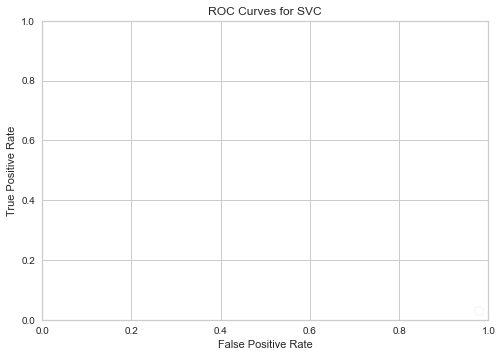

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [81]:
visualizer = ROCAUC(clf)
# visualizer.score(X, y)  # TODO: uncomment once scikit-learn is fixed
visualizer.show()

## Language Bindings

### Pybind11

[Pybind11](https://github.com/pybind/pybind11) makes writing bindings between Python and C++ enjoyable. In combination with [cppimport](https://github.com/tbenthompson/cppimport) some might even call it fun.
It is possible to implement [custom typecasters](https://pybind11.readthedocs.io/en/stable/advanced/cast/custom.html) to support bindings for arbitrary objects.

In [82]:
%%writefile cpp_source.cpp

#include <pybind11/pybind11.h>

namespace py = pybind11;


int square(int x) {
    return x * x;
}

PYBIND11_MODULE(cpp_source, m) {
    m.def(
        "square", &square,
        py::arg("x") = 1
    );
}

/*
<%
setup_pybind11(cfg)
cfg['compiler_args'] = ['-std=c++11']
%>
*/

Overwriting cpp_source.cpp


In [83]:
import cppimport

In [84]:
cpp_source = cppimport.imp('cpp_source')

In [85]:
cpp_source.square(5)

25

## Jupyter

### Nbstripout

Commiting Jupyter notebooks to CVS (e.g. git) can be annoying due to non-code properties being saved.
[Nbstripout](https://github.com/kynan/nbstripout) strips all of those away and can be run automatically for each committed notebook by executing `nbstripout --install` once.

## ToDo

* Validate your config files using [schemas](https://github.com/Julian/jsonschema/).
* Design your pipelines using [Snakemake](https://bitbucket.org/snakemake/snakemake).
* moviepy
* https://github.com/tqdm/tqdm
* https://github.com/pyca/cryptography
* https://github.com/jmoiron/humanize
* numba
* pythran
* https://github.com/cloudpipe/cloudpickle
* jupytext
* dfply(/plydata)
* tensorflow
* filprofiler
* https://github.com/mitmproxy/mitmproxy
* https://github.com/secdev/scapy
* https://github.com/emeryberger/scalene
* https://github.com/willmcgugan/rich
* https://github.com/joerick/pyinstrument
* https://github.com/nalepae/pandarallel/
* https://github.com/machow/siuba